In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import pytensor.tensor as pt

# HW9

## Q1

In [2]:
d = 1000

data = pd.read_csv("data/fire.csv").iloc[:200, 2:6]
m = 2
n, p = data.shape[0], data.shape[1] - m
X, Y = np.column_stack([np.ones(n), data.iloc[:, :p].values]), data.iloc[:, p:].values
Y1, Y2 = Y[:, 0], Y[:, 1]

with pm.Model() as marginal:
    alpha = pm.Exponential("alpha", lam=0.1)
    beta = pm.Exponential("beta", lam=0.1)
    y1 = pm.InverseGamma("y1", alpha=alpha, beta=beta, observed=Y1)
    mu = pm.Normal("mu", mu=80, sigma=5)
    sigma = pm.Exponential("sigma", lam=0.1)
    y2 = pm.Normal("y2", mu=mu, sigma=sigma, observed=Y2)
    idata1 = pm.sample(draws=d, chains=2, tune=100, random_seed=365)

az.summary(idata1, round_to=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, mu, sigma]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,11.101,1.115,8.946,13.067,0.034,0.031,1104.012,1006.917,1.001
beta,957.572,98.758,783.666,1150.141,2.953,2.772,1117.582,993.462,1.001
mu,84.686,2.736,79.063,89.013,0.247,0.177,147.947,140.014,1.019
sigma,42.368,2.121,38.704,46.694,0.054,0.052,1553.653,1143.846,1.000


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

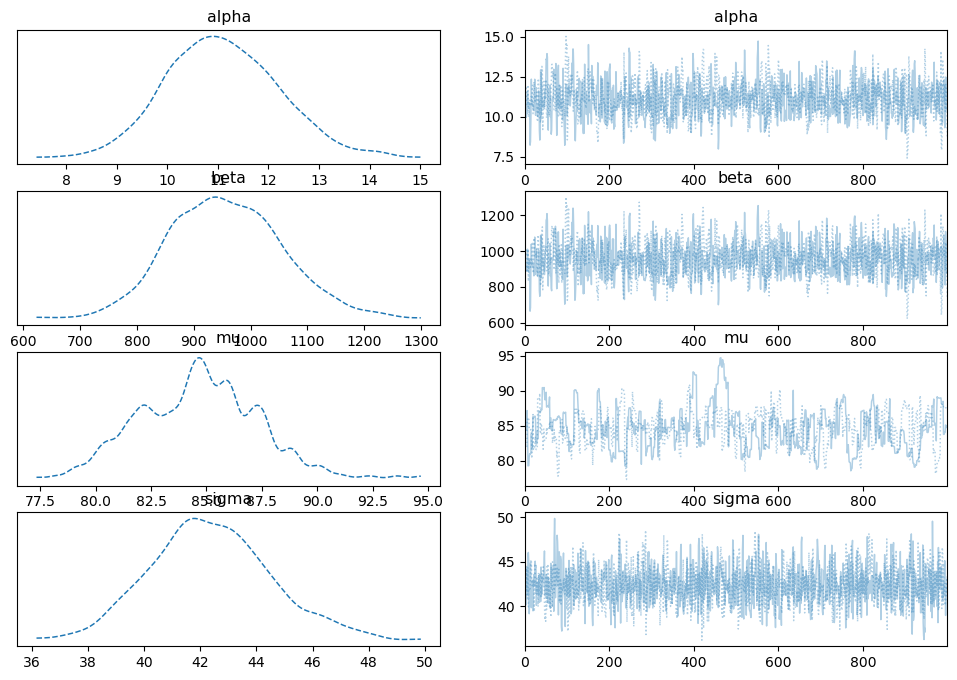

In [3]:
az.plot_trace(idata1, combined=True)

In [4]:
alpha = idata1.posterior["alpha"].mean().item()
beta = idata1.posterior["beta"].mean().item()
mu = idata1.posterior["mu"].mean().item()
sigma = idata1.posterior["sigma"].mean().item()
y1_uni = pt.exp(pm.logcdf(pm.InverseGamma.dist(alpha=alpha, beta=beta), Y1))
y2_uni = pt.exp(pm.logcdf(pm.Normal.dist(mu=mu, sigma=sigma), Y2))
y1_mul = pm.math.probit(y1_uni)
y2_mul = pm.math.probit(y1_uni)
Y_t = pt.math.stack([y1_mul, y2_mul], axis=1).eval()

with pm.Model() as copula:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2,
                                 sd_dist=pm.HalfNormal.dist(10, shape=m), compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    y = pm.MvNormal("y", mu=0, chol=L, observed=Y_t)
    idata2 = pm.sample(draws=d, chains=2, tune=100, random_seed=365)
    pm.sample_posterior_predictive(idata2, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [packed_L]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


A copula is a function that “couples” a multivariate distribution to its univariate marginals. It allows us to include the correlation between the variables.

The one pass approach fits the variables simultaneously, then transform them into normal distributions, and combine them together to form a multivariate normal distribution finally. The two pass approach does the same thing, but it fits the variables in one model, then transform them, and combine them in another model.

To build a multivariate GLM, first build several univariate GLMs separately. Then, transform them into the same scale. Finally, use a copula to represent the correlation.

## Q2

In [5]:
with pm.Model() as spike_slab:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2,
                                 sd_dist=pm.HalfNormal.dist(10, shape=m), compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    p_ = pm.Beta("p", alpha=1, beta=5)
    spike = pm.Bernoulli("spike", p=p_, shape=(p+1, m))
    slab = pm.Normal("slab", mu=0, sigma=10, shape=(p+1, m))
    betas = pm.Normal("betas", mu=spike*slab, sigma=1, shape=(p+1, m))
    y = pm.MvNormal("y", mu=X@betas, chol=L, observed=Y)
    idata3 = pm.sample(draws=d, chains=2, tune=100, random_seed=365)

az.summary(idata3, round_to=3)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [packed_L, p, slab, betas]
>BinaryGibbsMetropolis: [spike]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 1025 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",88.762,0.854,87.095,90.299,0.024,0.016,1255.143,1551.149,1.000
"betas[0, 1]",60.259,7.560,47.882,76.338,0.406,0.316,385.351,335.652,1.001
"betas[1, 0]",0.313,0.196,-0.086,0.642,0.006,0.004,1046.603,1169.277,1.000
"betas[1, 1]",4.960,1.832,1.001,8.094,0.101,0.081,392.135,307.735,1.001
"betas[2, 0]",1.692,6.340,-11.705,15.395,0.291,0.430,629.743,639.676,1.019
"betas[2, 1]",-0.393,5.702,-13.493,11.496,0.286,0.463,665.640,337.300,1.010
p,0.392,0.155,0.125,0.692,0.006,0.004,688.876,1080.538,1.003
packed_L[0],4.591,0.230,4.159,5.012,0.005,0.005,2001.732,1542.944,1.001
packed_L[1],20.191,2.871,14.475,25.326,0.069,0.076,1747.127,1044.526,1.001
packed_L[2],37.730,1.906,34.088,41.197,0.045,0.036,1822.178,1721.811,1.002


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>],
       [<Axes: title={'center': 'packed_L'}>,
        <Axes: title={'center': 'packed_L'}>],
       [<Axes: title={'center': 'slab'}>,
        <Axes: title={'center': 'slab'}>],
       [<Axes: title={'center': 'spike'}>,
        <Axes: title={'center': 'spike'}>]], dtype=object)

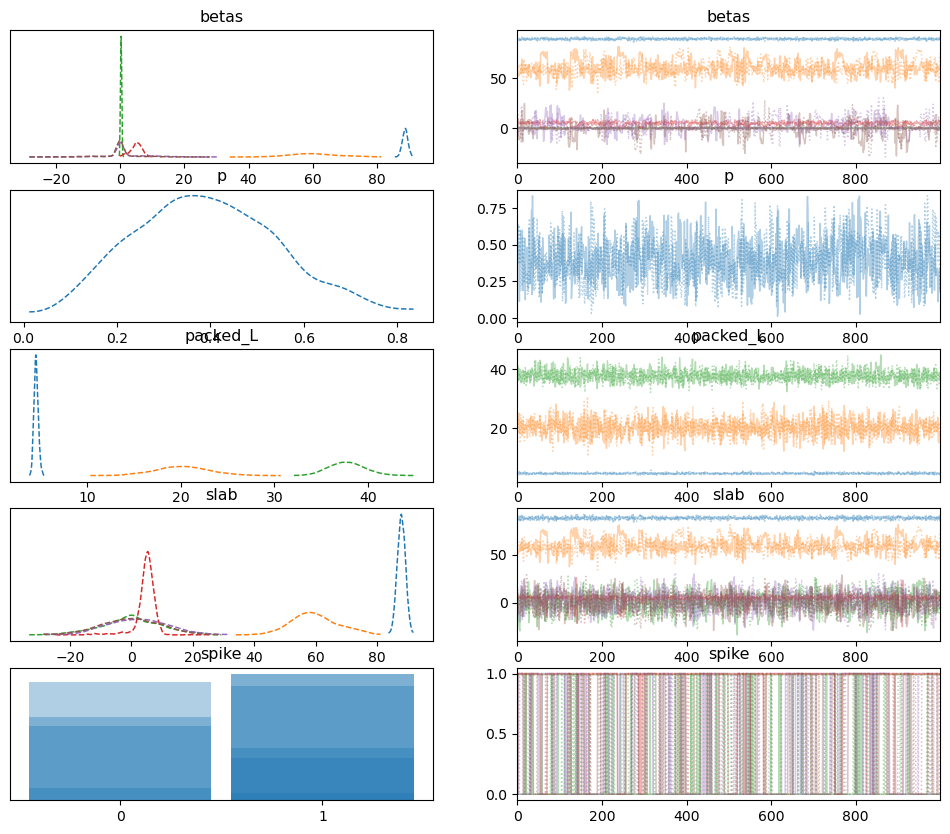

In [6]:
az.plot_trace(idata3, combined=True)

In [7]:
with pm.Model() as diffuse_normal:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2,
                                 sd_dist=pm.Exponential.dist(1, shape=m), compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal("betas", mu=0, sigma=100, shape=(p+1, m))
    y = pm.MvNormal("y", mu=X@betas, chol=L, observed=Y)
    idata4 = pm.sample(draws=d, chains=2, tune=100, random_seed=365)

az.summary(idata4, round_to=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 959 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",90.912,0.817,89.498,92.553,0.018,0.019,2062.494,1348.825,1.000
"betas[0, 1]",94.994,6.888,82.001,107.543,0.189,0.198,1337.523,906.261,1.002
"betas[1, 0]",-0.133,0.186,-0.504,0.200,0.004,0.004,2097.923,1716.045,1.000
"betas[1, 1]",-2.211,1.568,-5.018,0.947,0.041,0.042,1465.285,1220.534,1.001
"betas[2, 0]",15.485,21.181,-26.359,54.661,1.003,0.702,450.509,488.505,1.006
"betas[2, 1]",-62.423,102.409,-276.546,112.822,23.415,11.505,20.329,54.073,1.081
packed_L[0],4.440,0.217,4.015,4.849,0.005,0.005,1862.344,1196.043,1.003
packed_L[1],16.752,2.344,12.396,21.183,0.067,0.071,1215.059,840.286,1.003
packed_L[2],35.005,1.510,32.104,37.876,0.034,0.031,1999.536,1729.522,1.000


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'packed_L'}>,
        <Axes: title={'center': 'packed_L'}>]], dtype=object)

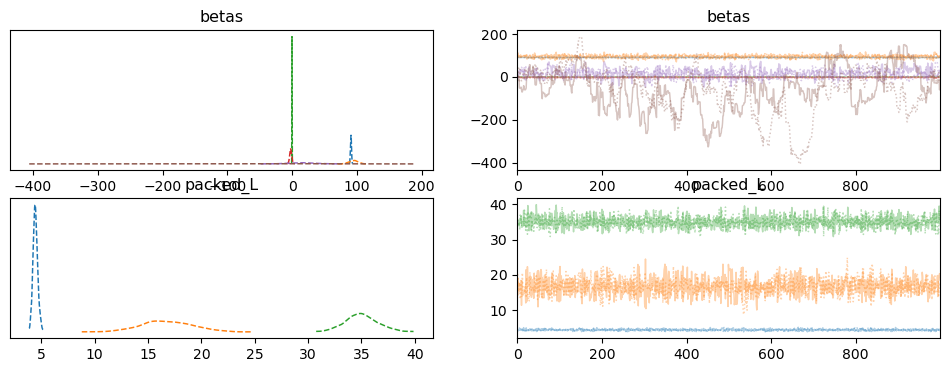

In [8]:
az.plot_trace(idata4, combined=True)

The spike and slab prior results in smaller $\beta$s than diffuse normal prior.

## Q3

In [9]:
with pm.Model() as horseshoe:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2,
                                 sd_dist=pm.HalfNormal.dist(10, shape=m), compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    tau = pm.HalfCauchy("tau", beta=0.1, shape=1)
    lambdas = pm.HalfCauchy("lambdas", beta=1, shape=(p+1, m))
    mu_ = pm.Normal("mu_", mu=0, sigma=1, shape=(p+1, m))
    betas = pm.Normal("betas", mu=mu_*tau*lambdas, sigma=1, shape=(p+1, m))
    y = pm.MvNormal("y", mu=X@betas, chol=L, observed=Y)
    idata5 = pm.sample(draws=d, chains=2, tune=100, random_seed=365)

az.summary(idata5, round_to=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [packed_L, tau, lambdas, mu_, betas]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 978 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",90.703,0.962,89.235,92.306,0.169,0.102,31.375,46.244,1.054
"betas[0, 1]",90.193,9.819,79.934,105.412,1.396,2.650,34.544,63.275,1.048
"betas[1, 0]",-0.078,0.221,-0.509,0.239,0.049,0.024,19.862,44.021,1.075
"betas[1, 1]",-1.095,2.070,-4.070,1.446,0.284,0.544,37.902,58.531,1.028
"betas[2, 0]",2.939,5.415,-6.024,15.612,0.781,0.771,54.542,77.968,1.020
"betas[2, 1]",-29.015,44.864,-111.795,10.965,29.974,14.525,2.889,17.530,1.867
"lambdas[0, 0]",48.243,126.350,0.601,154.333,13.988,34.741,16.897,140.079,1.105
"lambdas[0, 1]",44.838,97.062,0.511,148.540,9.600,14.889,9.474,122.523,1.160
"lambdas[1, 0]",0.767,1.945,0.000,2.115,0.162,0.678,100.434,303.790,1.021
"lambdas[1, 1]",0.965,2.158,0.000,2.839,0.250,0.616,11.116,334.640,1.126


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'lambdas'}>,
        <Axes: title={'center': 'lambdas'}>],
       [<Axes: title={'center': 'mu_'}>, <Axes: title={'center': 'mu_'}>],
       [<Axes: title={'center': 'packed_L'}>,
        <Axes: title={'center': 'packed_L'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

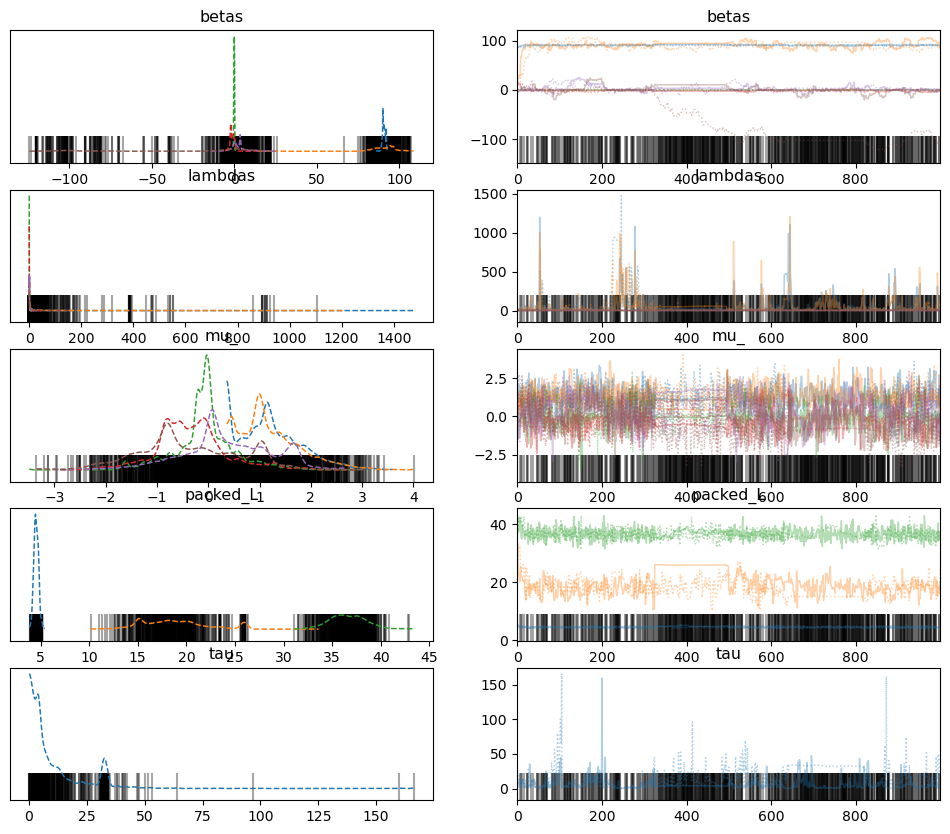

In [10]:
az.plot_trace(idata5, combined=True)

The horseshoe prior shrinks the $\beta$s towards zero, while the spike and slab prior shuts down some $\beta$s.